### Student Information
Name: 林育丞 Yu-Cheng Lin

Student ID: 112062595

GitHub ID: ryonaya

Kaggle name: X

Kaggle private scoreboard snapshot: X

---

### Instructions

1. First: __This part is worth 30% of your grade.__ Do the **take home exercises** in the [DM2024-Lab2-master Repo](https://github.com/didiersalazar/DM2024-Lab2-Master). You may need to copy some cells from the Lab notebook to this notebook. 


2. Second: __This part is worth 30% of your grade.__ Participate in the in-class [Kaggle Competition](https://www.kaggle.com/competitions/dm-2024-isa-5810-lab-2-homework) regarding Emotion Recognition on Twitter by this link: https://www.kaggle.com/competitions/dm-2024-isa-5810-lab-2-homework. The scoring will be given according to your place in the Private Leaderboard ranking: 
    - **Bottom 40%**: Get 20% of the 30% available for this section.

    - **Top 41% - 100%**: Get (0.6N + 1 - x) / (0.6N) * 10 + 20 points, where N is the total number of participants, and x is your rank. (ie. If there are 100 participants and you rank 3rd your score will be (0.6 * 100 + 1 - 3) / (0.6 * 100) * 10 + 20 = 29.67% out of 30%.)   
    Submit your last submission **BEFORE the deadline (Nov. 26th, 11:59 pm, Tuesday)**. Make sure to take a screenshot of your position at the end of the competition and store it as '''pic0.png''' under the **img** folder of this repository and rerun the cell **Student Information**.
    

3. Third: __This part is worth 30% of your grade.__ A report of your work developing the model for the competition (You can use code and comment on it). This report should include what your preprocessing steps, the feature engineering steps and an explanation of your model. You can also mention different things you tried and insights you gained. 


4. Fourth: __This part is worth 10% of your grade.__ It's hard for us to follow if your code is messy :'(, so please **tidy up your notebook**.


Upload your files to your repository then submit the link to it on the corresponding e-learn assignment.

Make sure to commit and save your changes to your repository __BEFORE the deadline (Nov. 26th, 11:59 pm, Tuesday)__. 

---
### Pre-setup

In [ ]:

#! Please change to your google news vector thingy 
model_path = "..\DM2024-Lab2-Master-main\GoogleNews\GoogleNews-vectors-negative300.bin.gz"

llm_model = "llama3.2" #You can change to the one of your preference

from gensim.models import KeyedVectors
w2v_google_model = KeyedVectors.load_word2vec_format(model_path, binary=True)
w2v_google_model.most_similar('happy', topn=10)


In [27]:
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.feature_extraction.text import CountVectorizer, TfidfVectorizer

train_df = pd.read_pickle("train_df.pkl")
test_df = pd.read_pickle("test_df.pkl")

import nltk
# nltk.download('punkt')        # << We should have this downloaded from Lab 1

BOW_500 = CountVectorizer(max_features=500, tokenizer=nltk.word_tokenize) 
BOW_500.fit(train_df['text'])
X_train = BOW_500.transform(train_df['text'])
y_train = train_df['emotion']
X_test = BOW_500.transform(test_df['text'])
y_test = test_df['emotion']

from sklearn.metrics import accuracy_score, confusion_matrix
from sklearn.naive_bayes import MultinomialNB

import keras
from sklearn.preprocessing import LabelEncoder
import numpy as np

label_encoder = LabelEncoder()
label_encoder.fit(y_train)

def label_encode(le, labels):
    enc = le.transform(labels)
    return keras.utils.to_categorical(enc)
def label_decode(le, one_hot_label):
    dec = np.argmax(one_hot_label, axis=1)
    return le.inverse_transform(dec)

from keras.models import Model
from keras.layers import Input, Dense
from keras.layers import ReLU, Softmax
from keras.callbacks import CSVLogger

word_list = ['happy', 'angry', 'sad', 'fear']
target_words = []
topn = 14
for word in word_list:
    target_words += [word] + [word_ for word_, sim_ in w2v_google_model.most_similar(word, topn=topn)]
cn = topn + 1
color = ['b'] * cn + ['g'] * cn + ['r'] * cn + ['y'] * cn

from sklearn.manifold import TSNE
import umap.umap_ as umap

import ollama
from IPython.display import display, Markdown, Latex

import bs4
from langchain.text_splitter import RecursiveCharacterTextSplitter
from langchain_community.document_loaders import WebBaseLoader
from langchain_community.vectorstores import Chroma
from langchain_community.embeddings import OllamaEmbeddings
from langchain_core.output_parsers import StrOutputParser
from langchain_core.runnables import RunnablePassthrough

# Function to load, split, and retrieve documents from multiple URLs
def load_and_retrieve_docs(url_list):
    all_docs = []
    for url in url_list:
        loader = WebBaseLoader(
            web_paths=(url,),
            bs_kwargs=dict() 
        ) 
        docs = loader.load() # Load the URL that will serve as our data source
        all_docs.extend(docs)
    
    text_splitter = RecursiveCharacterTextSplitter(chunk_size=1000, chunk_overlap=200) # Divide the URL in chunks of text for easier comparison in the vector space
    splits = text_splitter.split_documents(all_docs)
    #print(splits) # You can print this to see how the chunks in the URL were split
    print(f"Number of splits: {len(splits)}")
    embeddings = OllamaEmbeddings(model=llm_model) # Generating embeddings with our chosen model
    vectorstore = Chroma.from_documents(documents=splits, embedding=embeddings) # Our vector space for comparison
    return vectorstore.as_retriever()

def format_docs(docs):
    return "\n\n".join(doc.page_content for doc in docs) #Format the retrieved docs in an orderly manner for prompting

# Define the Ollama LLM function
def ollama_llm(question, context):
    formatted_prompt = f"Question: {question}\n\nContext: {context}"
    response = ollama.chat(model='llama3.2', messages=[{'role': 'user', 'content': formatted_prompt}])
    return response['message']['content']

# Define the RAG chain
def rag_chain(question, retriever):
    retrieved_docs = retriever.invoke(question)
    formatted_context = format_docs(retrieved_docs)
    return ollama_llm(question, formatted_context)

c:\Program Files\Python\Python310\lib\site-packages\sklearn\feature_extraction\text.py:521: UserWarning: The parameter 'token_pattern' will not be used since 'tokenizer' is not None'
  warnings.warn(


---
### First part : Take home exercises

##### ** >>> Exercise 1 (Take home): **  
Plot word frequency for Top 30 words in both train and test dataset. (Hint: refer to DM lab 1)


In [ ]:
# Answer here
def plot_word_frequency(data, title):
    # Vectorize the data
    vectorizer = CountVectorizer()
    X = vectorizer.fit_transform(data)
    X = X.toarray().sum(axis=0)
    words = vectorizer.get_feature_names_out()
    word_freq = list(zip(words, X))
    word_freq = sorted(word_freq, key=lambda x: x[1], reverse=True)
    word_freq = word_freq[:30]
    words, X = zip(*word_freq)
    plt.figure(figsize=(20, 10))
    sns.barplot(x=list(X), y=list(words))
    plt.title(title)
    plt.show()
    
plot_word_frequency(train_df["text"], "Word Frequency in Training Data")
plot_word_frequency(test_df["text"], "Word Frequency in Testing Data")

##### ** >>> Exercise 2 (Take home): **  
Generate an embedding using the TF-IDF vectorizer instead of th BOW one with 1000 features and show the feature names for features [100:110].

In [ ]:
TFIDF_1000 = TfidfVectorizer(max_features=1000, tokenizer=nltk.word_tokenize)
TFIDF_1000.fit(train_df['text'])
train_data_TFIDF_features_1000 = TFIDF_1000.transform(train_df['text'])
train_data_TFIDF_features_1000.toarray()
feature_names_TFIDF_1000 = TFIDF_1000.get_feature_names_out()
feature_names_TFIDF_1000[100:110]

##### ** >>> Exercise 3 (Take home): **  
Can you interpret the results above? What do they mean?

In [ ]:
# From the confusion matrix, we can see that the model performed mediocrely.

# Although the majority of the labels are on the diagonal line of the confusion matrix
# (which means that the model predicted the correct label), 
# there are still not a few labels that are not on the diagonal line. 

# Also from the accuracy, training accuracy is 0.99 while testing accuracy is only 0.68, 
# showing that the model did not generalize well to the testing data.

##### ** >>> Exercise 4 (Take home): **  
Build a model using a ```Naive Bayes``` model and train it. What are the testing results? 

*Reference*: https://scikit-learn.org/stable/modules/generated/sklearn.naive_bayes.MultinomialNB.html

In [ ]:
## build Naive Bayes model
NB_model = MultinomialNB()
NB_model = NB_model.fit(X_train, y_train)

y_train_pred = NB_model.predict(X_train)
y_test_pred = NB_model.predict(X_test)
acc_train = accuracy_score(y_true=y_train, y_pred=y_train_pred)
acc_test = accuracy_score(y_true=y_test, y_pred=y_test_pred)

print('training accuracy: {}'.format(round(acc_train, 2)))
print('testing accuracy: {}'.format(round(acc_test, 2)))

cm = confusion_matrix(y_true=y_test, y_pred=y_test_pred)
print(cm)

##### ** >>> Exercise 5 (Take home): **  

How do the results from the Naive Bayes model and the Decision Tree model compare? How do you interpret these differences? Use the theoretical background covered in class to try and explain these differences.

In [ ]:
# Decision Tree overfits the training data due to its ability to
# create complex decision boundaries.

# Naive Bayes is a simple model that assumes the features are independent of each other, 
# which prevents it from overfitting the training data, but also limits its ability to
# model complex relationships in the data.

# In this case, the data isn't simple enough for Naive Bayes to model well,
# nor is it complex enough for Decision Tree to model well.

##### ** >>> Exercise 6 (Take home): **  

Plot the Training and Validation Accuracy and Loss (different plots), just like the images below.(Note: the pictures below are an example from a different model). How to interpret the graphs you got? How are they related to the concept of overfitting/underfitting covered in class?

In [ ]:
#! Optional cell, the plot can be obtained for the training log.
#! Run this cell only if you want to refresh the log.

# only if y_train and y_test are 1D arrays (not one-hot encoded)
if len(y_train.shape) == 1:
    y_train = label_encode(label_encoder, y_train)
    y_test = label_encode(label_encoder, y_test)
    
input_shape = X_train.shape[1]
output_shape = len(label_encoder.classes_)

model_input = Input(shape=(input_shape, ))  # 500
X = model_input
X_W1 = Dense(units=64)(X)  # 64
H1 = ReLU()(X_W1)
H1_W2 = Dense(units=64)(H1)  # 64
H2 = ReLU()(H1_W2)
H2_W3 = Dense(units=output_shape)(H2)  # 4
H3 = Softmax()(H2_W3)
model_output = H3

# create model
model = Model(inputs=[model_input], outputs=[model_output])
model.compile(optimizer='adam',
              loss='categorical_crossentropy',
              metrics=['accuracy'])

csv_logger = CSVLogger('logs/training_log.csv')
epochs = 25
batch_size = 32

# training!
history = model.fit(X_train, y_train, 
                    epochs=epochs, 
                    batch_size=batch_size, 
                    callbacks=[csv_logger],
                    validation_data = (X_test, y_test))
pred_result = model.predict(X_test, batch_size=128)
pred_result = label_decode(label_encoder, pred_result)
print('testing accuracy: {}'.format(round(accuracy_score(label_decode(label_encoder, y_test), pred_result), 2)))

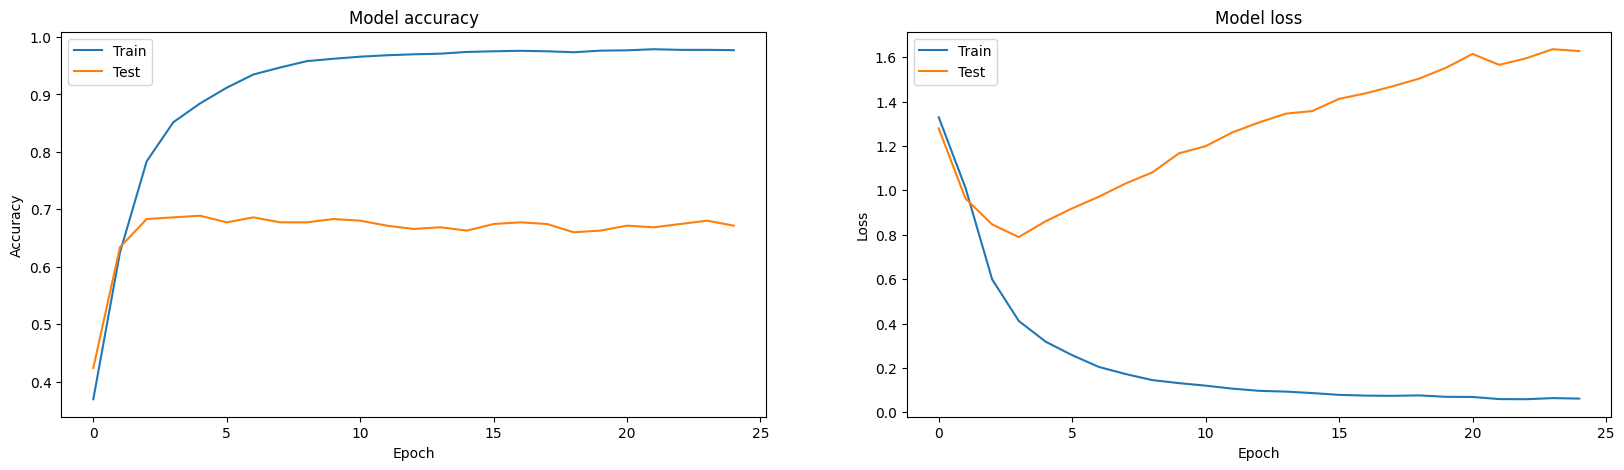

In [11]:
training_log = pd.DataFrame()
training_log = pd.read_csv("logs/training_log.csv")

# plot training & validation, accuracy & loss, in two subplots
fig, ax = plt.subplots(1, 2, figsize=(20, 5))

# plot accuracy
ax[0].plot(training_log['accuracy'])
ax[0].plot(training_log['val_accuracy'])
ax[0].set_title('Model accuracy')
ax[0].set_ylabel('Accuracy')
ax[0].set_xlabel('Epoch')
ax[0].legend(['Train', 'Test'], loc='upper left')

# plot loss
ax[1].plot(training_log['loss'])
ax[1].plot(training_log['val_loss'])
ax[1].set_title('Model loss')
ax[1].set_ylabel('Loss')
ax[1].set_xlabel('Epoch')
ax[1].legend(['Train', 'Test'], loc='upper left')

plt.show()

In [ ]:
# As the training progresses, 
# the training accuracy increases while the training loss decreases.
# However, the testing accuracy and loss do not show the same trend.

# The testing accuracy stabilizes at around 0.67 in very early epochs,
# while the testing loss reaches its minimum in the first few epochs and then increases.

# This indicates that the model is overfitting the training data.

##### ** >>> Exercise 7 (Take home): **  

Now, we have the word vectors, but our input data is a sequence of words (or say sentence). 
How can we utilize these "word" vectors to represent the sentence data and train our model?


In [ ]:
# We can use recurrent models such as LSTM or GRU to model the sequence data.
# Or pad the sequences and define a token limit, then use the good-old transformers.

##### ** >>> Exercise 8 (Take home): **  

Generate a t-SNE and UMAP visualization to show the 15 words most related to the words "angry", "happy", "sad", "fear" (60 words total). Compare the differences between both graphs.

c:\Program Files\Python\Python310\lib\site-packages\umap\umap_.py:1945: UserWarning: n_jobs value 1 overridden to 1 by setting random_state. Use no seed for parallelism.
  warn(f"n_jobs value {self.n_jobs} overridden to 1 by setting random_state. Use no seed for parallelism.")


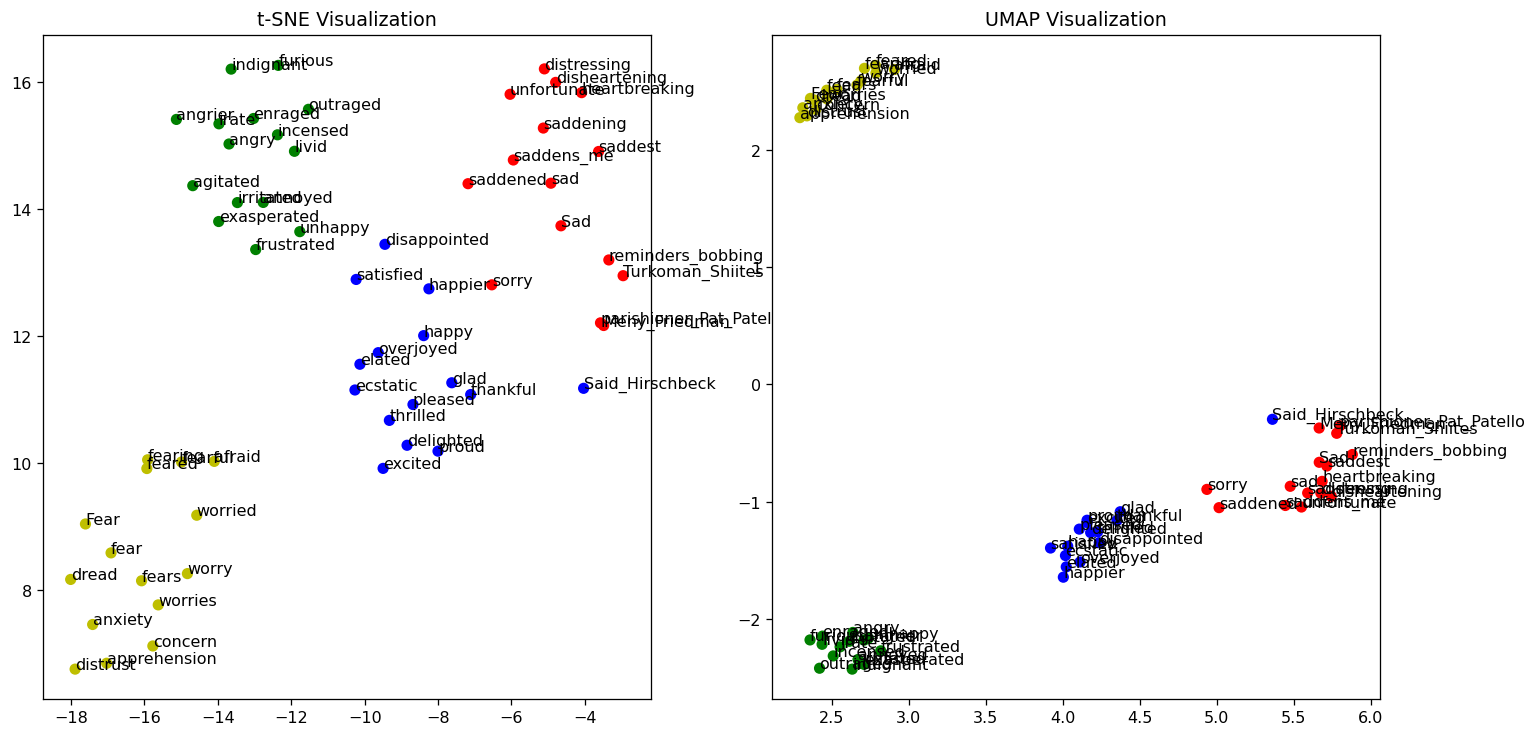

In [5]:
## w2v model
model = w2v_google_model

## prepare training word vectors
size = 200
target_size = len(target_words)
all_word = list(model.index_to_key)
word_train = target_words + all_word[:size]
X_train = model[word_train]

tsne = TSNE(n_components=2, metric='cosine', random_state=28)
umap_model = umap.UMAP(n_components=2, metric='cosine', random_state=28)

X_umap = umap_model.fit_transform(X_train)
X_tsne = tsne.fit_transform(X_train)

## plot the result in subplots
fig, ax = plt.subplots(1, 2, figsize=(15, 7.5), dpi=115)

# t-SNE plot
ax[0].scatter(X_tsne[:target_size, 0], X_tsne[:target_size, 1], c=color)
for label, x, y in zip(target_words, X_tsne[:target_size, 0], X_tsne[:target_size, 1]):
    ax[0].annotate(label, xy=(x, y), xytext=(0, 0), textcoords='offset points')
ax[0].set_title('t-SNE Visualization')

# UMAP plot
ax[1].scatter(X_umap[:target_size, 0], X_umap[:target_size, 1], c=color)
for label, x, y in zip(target_words, X_umap[:target_size, 0], X_umap[:target_size, 1]):
    ax[1].annotate(label, xy=(x, y), xytext=(0, 0), textcoords='offset points')
ax[1].set_title('UMAP Visualization')

plt.show()


In [6]:
# The distribution of the word vectors in UMAP is more dense and less scattered than t-SNE.
# But at least we can easily distinguish the clusters of the word vectors in both plots.

##### ** >>> Exercise 9 (Take home): **  

You noticed there is a **role** parameter inside the ollama.chat function, investigate what other roles there can be inside the function and what do they do. Give an example of a prompt using another role in additional to the **user** one.

In [8]:
# Answer here
# system: Sets the context in which to interact with the AI model. It typically includes rules, guidelines, or necessary information that help the model respond effectively.
# user: Represents the human interacting with the model. It includes the inputs, commands, and questions to the model.
# ipython: A new role introduced in Llama 3.1. Semantically, this role means "tool". This role is used to mark messages with the output of a tool call when sent back to the model from the executor.
# assistant: Represents the response generated by the AI model based on the context provided in the system, ipython and user prompts.

response = ollama.chat(model='llama3.2', messages=[
    {
        'role': 'system',
        'content': 'You are a barbarian in a fantasy world, and you know nothing about the modern world.'
    },
    {
        'role': 'user',
        'content': 'What is data mining? (in markdown format)'
    },
])

display(Markdown(response['message']['content']))

*grumble grumble* Me no understand "data mining". What mean "data"? Is it like collecting berries for tribe's dinner? *scratches head*

**Me Think...**

* Data be like pile of stones. Each stone have mark on it, like number or picture.
* Data mining be like searching through pile of stones to find special ones, like shiny rock with many marks on it.
* But why search for special rocks when we already know what we looking for?

**Me Not Understand**

* How you know which rocks are "special"? Is it like magic? Do you have special tools that make rocks talk?
* Why bother searching through pile of stones if we can just ask other tribe members what they know?
* Me think data mining be weird practice... *shrugs*

Uh, me no understand "data mining".

##### ** >>> Exercise 10 (Take home): **  

Try asking the model with one image of your choosing. Is the description accurate? Why?

In [23]:
response = ollama.chat(model='llava-phi3', messages=[
    {
        'role': 'user',
        'content': '''
            In the given image, there is a list of player names. 
            I need to extract the player names from the image, please list the player names.
        ''',
        'images': ['./pics/TARGET.png'] # Screenshot that contains the list of player names
    },
])

display(Markdown(response['message']['content']))

13 thunggis Ahunas Velde Alexei Melikov Alexi Samoilov Aleksiej Kriss Aranghel3 Boe-Ing Eva Boria Guiuili St Haou I Hou See Mei Jack Strummer Kosmakoulu Leonenpele Mngust Mikhail Nabin Masuzco M Habin Mikk1228 Neon Havoc Outfix Sca Li Shain Kim Tsumitsu Takamura ValentinoNockka

In [17]:
# Pretty impressive, even though it is not trained to do OCR, 
# it still managed to extract the player names from the image, 
# with decent accuracy.

##### ** >>> Exercise 11 (Take home): **  

Try to modify the code to make it accept **three URLs**, or **three text documents** of your choosing. After modifying it, make **three prompts/questions** with information that can be found in each of the documents/urls, **compare the accuracy of the response** with the actual answer. Investigate and discuss the advantages and disadvantages of RAG systems.

In [ ]:

#! WARNING, this will take 5+ mins to run
# You can skip this one since I saved the response in the response.txt file

# URLs for the recent three big update notes in EVE Online
url_list = ["https://www.eveonline.com/news/view/revenant-expansion-notes",
            "https://www.eveonline.com/news/view/equinox-expansion-notes",
            "https://www.eveonline.com/news/view/havoc-expansion-notes"]

# Combine the documents from the URLs
retriever = load_and_retrieve_docs(url_list)

Number of splits: 127


In [ ]:
# You can skip this one if you skipped the previous cell.

# Note, all of the RAG are from the same retriever, 
# which should theoretically contain all the information from the three URLs.

# 1. General questions
response11 = rag_chain("What is the new feature in Revenant?", retriever)
response21 = rag_chain("What is the new feature in Equinox?", retriever)
response31 = rag_chain("What is the new feature in Havoc?", retriever)

# 2. Specific questions
response12 = rag_chain("What are the new ships in Revenant, name a few.", retriever)
response22 = rag_chain("What are the new ships in Equinox, name a few.", retriever)
response32 = rag_chain("What are the new ships in Havoc, name a few.", retriever)

# 3. Detailed questions
response13 = rag_chain("Can a Cenotaph fit a Covert Ops Cloaking Device?", retriever)
response23 = rag_chain("After the Equinox expansion, what is the payout for a group of 5 players?", retriever)
response33 = rag_chain("Building a Komodo, how many Capital Propulsion Engines are needed after Havoc expansion?", retriever)

In [31]:
# You can also skip this one if you skipped the previous cell.

# save the responses in a list
responses = [response11, response21, response31, response12, response22, response32, response13, response23, response33]
with open("responses.txt", "w") as f:
    for response in responses:
        f.write(response + "\n\n")
        f.write("--------------------------------------------------\n\n")

In [ ]:
# Analyzing the responses using my brain.

# Avg score : 1.77 / 5
# Reliable? : No

# 1-1 : Features of Revenant
#   score : 0 / 5
#   reason: All of the feature mentioned are in Equinox.
# 1-2 : Features of Equinox
#   score : 4 / 5
#   reason: Correct features are mentioned, although the deathless ships are from Revenant.
# 1-3 : Features of Havoc
#   score : 0 / 5
#   reason: All of the feature mentioned are in Equinox.

# 2-1 : Ships of Revenant
#   score : 2 / 5
#   reason: The content is fragmented and not logically structured, although all from Revenant.
# 2-2 : Ships of Equinox
#   score : 0 / 5
#   reason: Misunderstood the question and answered about Revenant.
# 2-3 : Ships of Havoc
#   score : 0 / 5
#   reason: Misunderstood the question and answered about Revenant.

# 3-1 : Cenotaph fitting
#   score : 1 / 5
#   reason: Everything is wrong, except for the ship can indeed fit a Medium Breacher Pod Launcher.
# 3-2 : Payout for 5 players
#   score : 1 / 5
#   reason: Cannot find the answer, but at least suggested us to check the official website.
# 3-3 : Building a Komodo
#   score : 0 / 5
#   reason: Cannot find relevant information, the data retrieved seems like from Equinox.

##### ** >>> Exercise 12 (Take home): **

Follow Exercise 6 again and Plot the Training and Validation Accuracy and Loss for the results of this Neural Network. Compare the results of both KNN and the NN we just implemented. Discuss about why we obtained these results with the LLM Embeddings compared to the results of the other models implemented in this Lab.

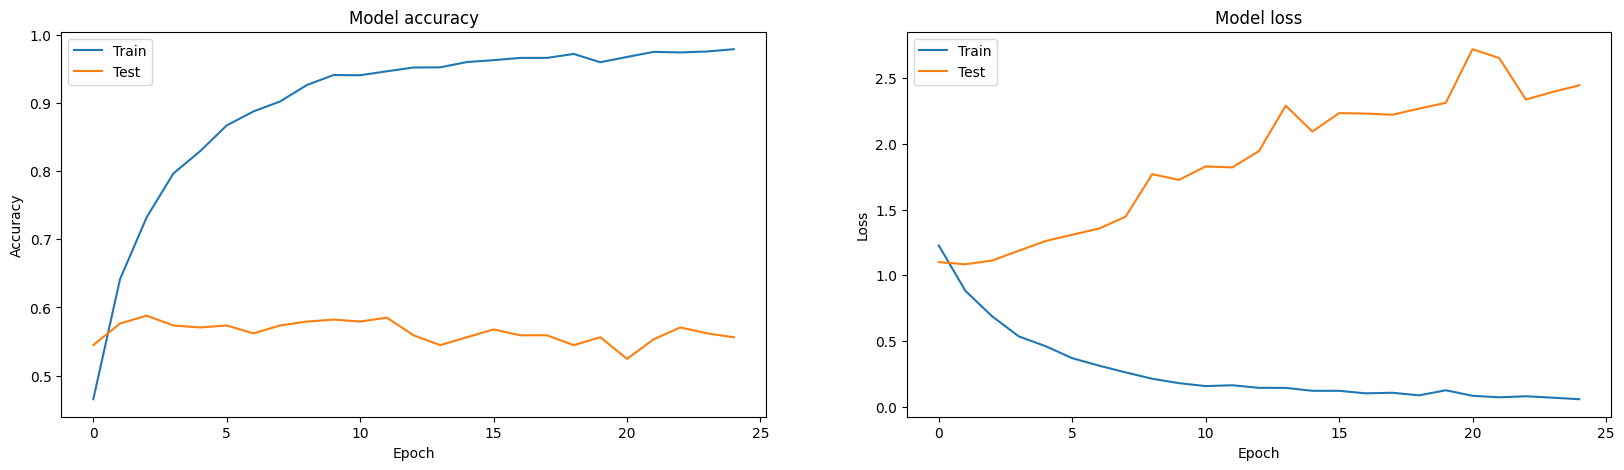

In [33]:
# I'll skip the training part since we can plot with the training log 2.
training_log2 = pd.read_csv("logs/training_log_2.csv")

# plot training & validation, accuracy & loss, in two subplots
fig, ax = plt.subplots(1, 2, figsize=(20, 5))

# plot accuracy
ax[0].plot(training_log2['accuracy'])
ax[0].plot(training_log2['val_accuracy'])
ax[0].set_title('Model accuracy')
ax[0].set_ylabel('Accuracy')
ax[0].set_xlabel('Epoch')
ax[0].legend(['Train', 'Test'], loc='upper left')

# plot loss
ax[1].plot(training_log2['loss'])
ax[1].plot(training_log2['val_loss'])
ax[1].set_title('Model loss')
ax[1].set_ylabel('Loss')
ax[1].set_xlabel('Epoch')
ax[1].legend(['Train', 'Test'], loc='upper left')

plt.show()

In [34]:
# The accuracy for KNN is 0.46, which is not good.
# The accuracy for the NN is 0.56, which is a bit better than KNN.

# The KNN is probably too simple to model the complex high-dimensional data.
# The NN is a bit better, but still overfitting the training data, 
# as we can see from the plot, it has the same trend as the previous exercise.

# The complexity of the embeddings (3072-D) probably 
# requires a way bigger dataset to train the model properly, 
# as the embeddings are originally designed to cover a very wide range of data.

##### ** >>> Exercise 13 (Take home): **

Compare and discuss the results of the zero-shot, 1-shot and 5-shot classification.

In [35]:
# I've run each experiment 3 times, the result is not consistent,
# but we can see the trend that the accuracy of 1-shot > 0-shot > 5-shot.

# 0-shot accuracy is around 0.49,
# 1-shot accuracy is around 0.52,
# 5-shot accuracy is around 0.46.

# The 1-shot seems to perform the best, but the difference is not that significant.

# The test_sample is probably too small to get a consistent result,
# or the 3B model isn't big enough to capture the nuances of the emotion data.

---
### Second part : Kaggle Competition

##### Setup the environment for kaggel and prepare the data for the competition.